unmeasured length 351


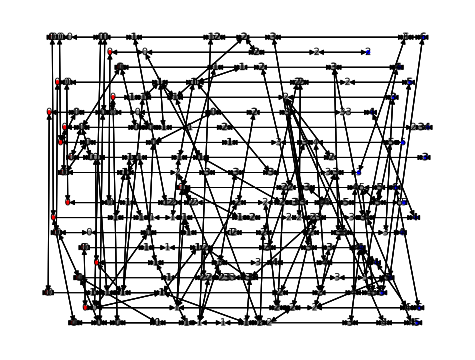

In [2]:
from Partition import *

NQubit = 20
Depth = 200

def main():
    gs, input_nodes, node_pos, colors = generate_graph_state(NQubit, Depth)
    gs = partition(gs, input_nodes)
    labels = nx.get_node_attributes(gs, 'layer')
    nx.draw(gs, pos = node_pos, node_color = colors, node_size = 10, labels = labels,  font_size=10)
    return

if __name__ == '__main__':
    main()